## Exporting the modules 

In [1]:
using Printf
using Plots
using Oceananigans
using Oceananigans.Utils
using Oceananigans.Units: minutes, hour, hours, day
using Oceananigans.Grids: nodes
using Oceananigans.Diagnostics
using Oceananigans.OutputWriters: JLD2OutputWriter, FieldSlicer, TimeInterval
using Oceananigans.Diagnostics: accurate_cell_advection_timescale

## Defining Grid

In [2]:
#number of grid spacing in south,north and vertical direction
const Nx=256
const Ny=256
const Nz=64

#Length of grid in south, north and vertical direction
const Lx=4
const Ly=4
const Lz=0.1

const S = 1.6 # Stretching factor
hyperbolically_spaced_nodes(k) = -Lz-Lz*(tanh(S * ( (-(k-Nz-1) ) / Nz - 1)) / tanh(S))
computational_grid = VerticallyStretchedRectilinearGrid(size = (Nx, Ny, Nz), 
                                                               architecture = CPU(),
                                                               x = (0,Lx),
                                                               y = (0,Ly),
                                                               halo = (3, 3, 3),
                                                               z_faces = hyperbolically_spaced_nodes)


VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 4.0], y ∈ [0.0, 4.0], z ∈ [-0.1, 0.0]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (256, 256, 64)
   halo size (Hx, Hy, Hz): (3, 3, 3)
grid spacing (Δx, Δy, Δz): (0.015625, 0.015625, [min=0.0004178411847718111, max=0.0027119068833282023])

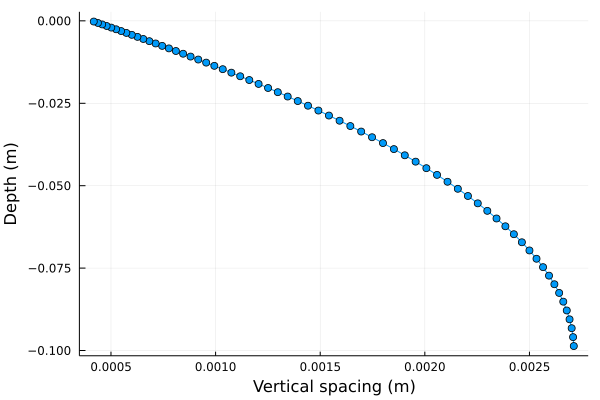

In [3]:
plot(computational_grid.Δzᵃᵃᶜ[1:Nz], computational_grid.zᵃᵃᶜ[1:Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Vertical spacing (m)",
     legend = nothing)

In [4]:
# z_face = computational_grid.zᵃᵃᶠ[1:65]
# outfile = "zface.txt"
# open(outfile, "w") do f
#   for i in z_face
#     println(f, i)
#   end
# end # the file f is automatically closed after this block finishes

## Governing parameters

In [5]:
#Coefficient of Thermal expansion
const alpha= 2e-4

#Coefficient of Salinity
const beta=8e-4

#diffusive viscocity
const v=1e-5 
#diffusivity
const k=2e-6 

const f=0   #coriolis parameter
 
g = 300

300

## Boundary conditions

### Temperature(Tracer) boundary condition

In [6]:
Amplitude = 950 # Amplitude (W/m²) of Heat flux

Q_cool = -143.1092 # (W/m²) {due to Longwave + Latent heat + Sensible Heat}

gausian(t) =  exp(-((t)^2)/(0.025*(86400)^2)) 

# These are the times during which peak of the heat flux can be observed
peak1 = 0.56day
peak2 = 1.56day
peak3 = 2.56day
peak4 = 3.56day
peak5 = 4.56day
peak6 = 5.56day

# Heat absorbed due to shortwave
Q_sh(t) = Amplitude*(gausian(t-peak1) + gausian(t-peak2) + gausian(t-peak3) + gausian(t-peak4)+ gausian(t-peak5)+ gausian(t-peak6) )


Q_sh (generic function with 1 method)

In [7]:
Q_net(t) = Q_sh(t) + Q_cool

Q_net (generic function with 1 method)

In [8]:
0.56day

48384.00000000001

In [9]:
function heatflux(t)
    if Q_net(t) <= 0
        bias = 1
        multiplier = 0
    else
        bias = 0
        multiplier = 1
    end
    
    return Q = bias*Q_cool
end

heatflux (generic function with 1 method)

In [10]:
t = 48384.00000000001
heatflux(t)

-0.0

In [11]:
dTdz = 0
T_bcs = FieldBoundaryConditions( top = FluxBoundaryCondition(heatflux(t)),
                                 bottom = GradientBoundaryCondition(dTdz))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

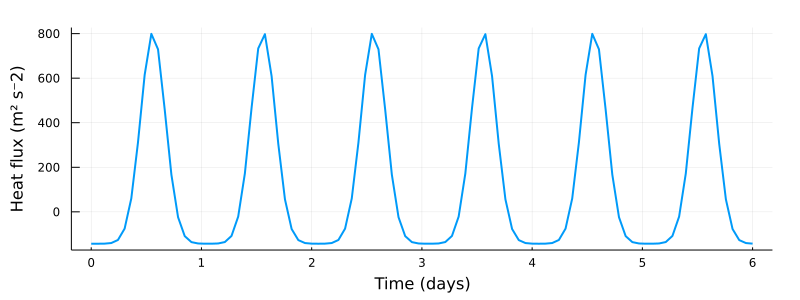

In [12]:
using Plots, Measures
time = range(0, 6day, length=100)

flux_plot = plot(time ./ day, [Q_net(t) for t in time],
                 linewidth = 2, xlabel = "Time (days)", ylabel = "Heat flux (m² s⁻2)",
                 size = (800, 300), margin = 5mm, label = nothing)

### Defining Heat Source Term as a forcing

In [13]:

function ShortWavePenetration(x,y,z,t)
    
    if Q_net(t) <= 0
        bias = 1
        multiplier = 0
    else
        bias = 0
        multiplier = 1
    end
    
    Q_band1(z) = (Ι/λ1)*exp(-z/λ1) 
    Q_band2(z) = (Ι/λ2)*exp(-z/λ2)
    
    if  z >= computational_grid.zᵃᵃᶜ[Nz]
        cooling_source = multiplier*Q_cool/(ρ*Cp*computational_grid.Δzᵃᵃᶜ[i])
        return Q_sh(t) * (Q_band1(z) + Q_band2(z))/(ρ*Cp) + (cooling_source*computational_grid.Δzᵃᵃᶜ[i])

    else 
        return Q_sh(t) * (Q_band1(z) + Q_band2(z))/(ρ*Cp)
    end

end

ShortWavePenetration_parameters = (ρ = 1000,
                                   Cp = 4182,
                                   λ1 = 0.35,
                                   λ2 = 23.0,
                                   Ι = 0.58
                                    )

(ρ = 1000, Cp = 4182, λ1 = 0.35, λ2 = 23.0, Ι = 0.58)

In [14]:
heat_source_term = Forcing(ShortWavePenetration,
                            parameters = ShortWavePenetration_parameters)

ContinuousForcing{NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}}}
├── func: ShortWavePenetration
├── parameters: (ρ = 1000, Cp = 4182, λ1 = 0.35, λ2 = 23.0, Ι = 0.58)
└── field dependencies: ()

### Velocity Boundary conditions

In [15]:
const Qᵘ=0
u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ), bottom=ValueBoundaryCondition(0.0))
v_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ), bottom=ValueBoundaryCondition(0.0))


Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

## Buoyancy that depends on temperature and salinity

We use the SeawaterBuoyancy model with a linear equation of state,

In [16]:
buoyancy = SeawaterBuoyancy(gravitational_acceleration = g,equation_of_state=LinearEquationOfState(α=alpha, β=beta))

SeawaterBuoyancy{Float64}: g = 300.0
└── equation of state: LinearEquationOfState{Float64}: α = 2.00e-04, β = 8.00e-04



## Model instantiation

In [17]:
using Oceananigans.Advection
using Oceananigans.TurbulenceClosures

model = NonhydrostaticModel(architecture = CPU(),
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            grid = computational_grid,
                            tracers = (:T, :S),
                            coriolis = FPlane(f=f),
                            buoyancy = buoyancy,
                            closure = SmagorinskyLilly(),
                            forcing = (T=heat_source_term,),
                            boundary_conditions = (u=u_bcs, v=v_bcs, T=T_bcs))

NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=256, Ny=256, Nz=64)
├── tracers: (:T, :S)
├── closure: SmagorinskyLilly{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, NamedTuple{(:T, :S), Tuple{Float64, Float64}}}
├── buoyancy: SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}
└── coriolis: FPlane{Float64}

## Setting Initial Conditions

In [18]:
using CSV
using DataFrames

In [19]:
initial_temperature = Matrix(CSV.read("initial_temperature.csv", DataFrame))

64×1 Matrix{Float64}:
 10.294401055765555
 10.331833316822966
 10.380041811498705
 10.441774516109785
 10.520602718540681
 10.620683031146738
 10.747011033259266
 10.905434838988407
 11.10233033898583
 11.345072184635535
 11.64065615364561
 11.996896043662773
 12.4194309934701
  ⋮
 26.77108985690285
 26.791391588764597
 26.809718736691018
 26.826291579415113
 26.841311165514334
 26.854949253897722
 26.86734312673584
 26.878654489499457
 26.888966863504148
 26.898408239674765
 26.90527136172108
 26.9073934063624

In [20]:
itemp = zeros(256, 256, 64)
for x ∈ 1:256
    for y ∈ 1:256
        itemp[x,y,:] = initial_temperature
    end
end

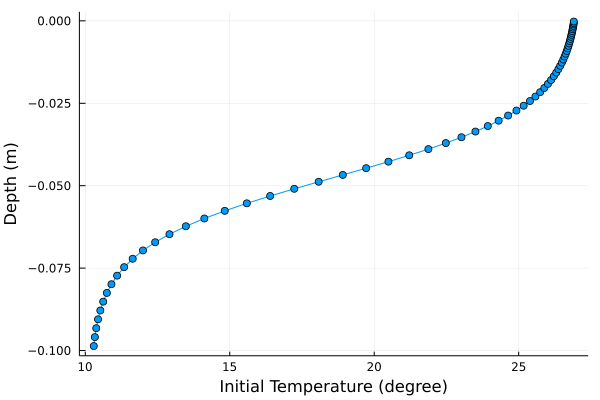

In [21]:
plot(initial_temperature[:,1],computational_grid.zᵃᵃᶜ[1:Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Initial Temperature (degree)",
     legend = nothing)

In [22]:
initial_salinity = Matrix(CSV.read("initial_salinity.csv", DataFrame))

64×1 Matrix{Float64}:
 34.80747952602548
 34.81508852016174
 34.82485636031105
 34.83729908348619
 34.853063588392644
 34.87285937928184
 34.89747707259633
 34.92774741987654
 34.96443137076576
 35.00823462441043
 35.05952714623703
 35.11846248058543
 35.18456361397405
  ⋮
 36.23494197738448
 36.23561854821235
 36.23622789471926
 36.23677772096786
 36.23727501983475
 36.23772573857827
 36.238134616107345
 36.23850719867827
 36.23884635005251
 36.2391564318519
 36.239381567843694
 36.2394511426444

In [23]:
isal = zeros(256, 256, 64)
for x ∈ 1:256
    for y ∈ 1:256
        isal[x,y,:] = initial_salinity
    end
end

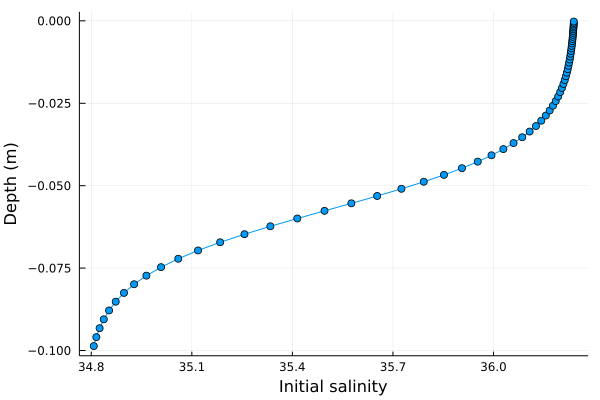

In [24]:
plot(initial_salinity,computational_grid.zᵃᵃᶜ[1:Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Initial salinity",
     legend = nothing)

In [25]:
# `set!` the `model` fields using functions or constants:
set!(model, T = itemp, S = isal)

## Setting up a simulation

We first build a TimeStepWizard to ensure stable time-stepping with a Courant-Freidrichs-Lewy (CFL) number of 0.5.

In [26]:
using Oceananigans.Diagnostics: accurate_cell_advection_timescale
wizard = TimeStepWizard(cfl=0.5,Δt=0.1, max_change=1.1, max_Δt=1minutes,cell_advection_timescale = accurate_cell_advection_timescale)


TimeStepWizard{Float64, typeof(accurate_cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}(0.5, Inf, 1.1, 0.5, 60.0, 0.0, 0.1, Oceananigans.Diagnostics.accurate_cell_advection_timescale, Oceananigans.Simulations.infinite_diffusion_timescale)

Nice progress messaging is helpful:

In [27]:
start_time = time_ns() # so we can print the total elapsed wall time

# Print a progress message
progress_message(sim) =
    @printf("i: %04d, t: %s, Δt: %s, wmax = %.1e ms⁻¹, wall time: %s\n",
            sim.model.clock.iteration, prettytime(model.clock.time),
            prettytime(wizard), maximum(abs, sim.model.velocities.w),
            prettytime((time_ns() - start_time) * 1e-9))


progress_message (generic function with 1 method)

We then set up the simulation:

In [28]:
simulation = Simulation(model,
                    Δt = wizard,
             stop_time = 10minutes,
    iteration_interval = 1,
              progress = progress_message
)

┌ Warning: You have used the default iteration_interval=1. This simulation will recalculate the time step every iteration which can be slow.
└ @ Oceananigans.Simulations C:\Users\My Account\.julia\packages\Oceananigans\Jog3t\src\Simulations\simulation.jl:70


Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0 
├── Next time step (TimeStepWizard{Float64, typeof(accurate_cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}): 100 ms 
├── Iteration interval: 1
├── Stop criteria: Any[Oceananigans.Simulations.iteration_limit_exceeded, Oceananigans.Simulations.stop_time_exceeded, Oceananigans.Simulations.wall_time_limit_exceeded]
├── Run time: 0 seconds, wall time limit: Inf
├── Stop time: 10 minutes, stop iteration: Inf
├── Diagnostics: typename(OrderedCollections.OrderedDict) with 1 entry:
│   └── nan_checker => typename(NaNChecker)
└── Output writers: typename(OrderedCollections.OrderedDict) with no entries

## Output

In [29]:

fields = Dict("u" => model.velocities.u,"v" => model.velocities.v,"w" => model.velocities.w, "T" => model.tracers.T)

simulation.output_writers[:fields] =
    NetCDFOutputWriter(model, fields, filepath="DevangSetup.nc",
                       schedule=TimeInterval(6) )


┌ Warning: DevangSetup.nc already exists but no NetCDFOutputWriter mode was explicitly specified. Will default to mode = "a" to append to existing file. You might experience errors when writing output if the existing file belonged to a different simulation!
└ @ Oceananigans.OutputWriters C:\Users\My Account\.julia\packages\Oceananigans\Jog3t\src\OutputWriters\netcdf_output_writer.jl:290


NetCDFOutputWriter scheduled on TimeInterval(6 seconds):
├── filepath: DevangSetup.nc
├── dimensions: zC(64), zF(65), xC(256), yF(256), xF(256), yC(256), time(0)
├── 4 outputs: ["v", "w", "T", "u"]
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
└── array type: Array{Float32}

We're ready:

In [30]:
run!(simulation)

LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching ShortWavePenetration(::Float64, ::Float64, ::Float64, ::Float64, ::NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}})
    [0mClosest candidates are:
    [0m  ShortWavePenetration(::Any, ::Any, ::Any, ::Any) at In[13]:2
    Stacktrace:
      [1] [0m[1mcall[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Cassette\N5kbV\src\[39m[90;4mcontext.jl:456[0m[90m [inlined][39m
      [2] [0m[1mfallback[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Cassette\N5kbV\src\[39m[90;4mcontext.jl:454[0m[90m [inlined][39m
      [3] [0m[1m_overdub_fallback(::Any, ::Vararg{Any, N} where N)[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Cassette\N5kbV\src\[39m[90;4moverdub.jl:582[0m[90m [inlined][39m
      [4] [0m[1moverdub[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Cassette\N5kbV\src\[39m[90;4moverdub.jl:582[0m[90m [inlined][39m
      [5] [0m[1moverdub[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Oceananigans\Jog3t\src\Forcings\[39m[90;4mcontinuous_forcing.jl:113[0m[90m [inlined][39m
      [6] [0m[1moverdub[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\Oceananigans\Jog3t\src\Models\NonhydrostaticModels\[39m[90;4mvelocity_and_tracer_tendencies.jl:186[0m[90m [inlined][39m
      [7] [0m[1moverdub[22m
    [90m    @ [39m[90mC:\Users\My Account\.julia\packages\KernelAbstractions\8W8KX\src\[39m[90;4mmacros.jl:266[0m[90m [inlined][39m
      [8] [0m[1m__thread_run[22m[0m[1m([22m[90mtid[39m::[0mInt64, [90mlen[39m::[0mInt64, [90mrem[39m::[0mInt64, [90mobj[39m::[0mKernelAbstractions.Kernel[90m{KernelAbstractions.CPU, KernelAbstractions.NDIteration.StaticSize{(16, 16)}, KernelAbstractions.NDIteration.StaticSize{(256, 256, 64)}, typeof(Oceananigans.Models.NonhydrostaticModels.cpu_calculate_Gc!)}[39m, [90mndrange[39m::[0mNothing, [90miterspace[39m::[0mKernelAbstractions.NDIteration.NDRange[90m{3, KernelAbstractions.NDIteration.StaticSize{(16, 16, 64)}, KernelAbstractions.NDIteration.StaticSize{(16, 16, 1)}, Nothing, Nothing}[39m, [90margs[39m::[0mTuple[90m{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Val{1}, UpwindBiasedFifthOrder, SmagorinskyLilly{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, NamedTuple{(:T, :S), Tuple{Float64, Float64}}}, Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.BuoyancyModels.ZDirection}, NamedTuple{(:velocities, :tracers), Tuple{NamedTuple{(:u, :v, :w), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}, NamedTuple{(:T, :S), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}}}, NamedTuple{(:u, :v, :w), Tuple{Field{Face, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Face, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Face, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:T, :S), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:νₑ, :κₑ), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, NamedTuple{(:T, :S), Tuple{Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity3), typeof(Oceananigans.Operators.identity4), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity5), typeof(Oceananigans.Operators.identity1), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity2), typeof(Oceananigans.Operators.identity3), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity4), typeof(Oceananigans.Operators.identity5), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}}}}}, Oceananigans.Forcings.ContinuousForcing{Center, Center, Center, NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}}, typeof(ShortWavePenetration), Tuple{}, Tuple{}, Tuple{}}, Clock{Float64}}[39m, [90mdynamic[39m::[0mKernelAbstractions.NDIteration.NoDynamicCheck[0m[1m)[22m
    [90m    @ [39m[35mKernelAbstractions[39m [90mC:\Users\My Account\.julia\packages\KernelAbstractions\8W8KX\src\[39m[90;4mcpu.jl:157[0m
      [9] [0m[1m__run[22m[0m[1m([22m[90mobj[39m::[0mKernelAbstractions.Kernel[90m{KernelAbstractions.CPU, KernelAbstractions.NDIteration.StaticSize{(16, 16)}, KernelAbstractions.NDIteration.StaticSize{(256, 256, 64)}, typeof(Oceananigans.Models.NonhydrostaticModels.cpu_calculate_Gc!)}[39m, [90mndrange[39m::[0mNothing, [90miterspace[39m::[0mKernelAbstractions.NDIteration.NDRange[90m{3, KernelAbstractions.NDIteration.StaticSize{(16, 16, 64)}, KernelAbstractions.NDIteration.StaticSize{(16, 16, 1)}, Nothing, Nothing}[39m, [90margs[39m::[0mTuple[90m{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Val{1}, UpwindBiasedFifthOrder, SmagorinskyLilly{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, NamedTuple{(:T, :S), Tuple{Float64, Float64}}}, Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.BuoyancyModels.ZDirection}, NamedTuple{(:velocities, :tracers), Tuple{NamedTuple{(:u, :v, :w), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}, NamedTuple{(:T, :S), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}}}, NamedTuple{(:u, :v, :w), Tuple{Field{Face, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Face, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Face, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:T, :S), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:νₑ, :κₑ), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, NamedTuple{(:T, :S), Tuple{Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity3), typeof(Oceananigans.Operators.identity4), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity5), typeof(Oceananigans.Operators.identity1), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity2), typeof(Oceananigans.Operators.identity3), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity4), typeof(Oceananigans.Operators.identity5), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}}}}}, Oceananigans.Forcings.ContinuousForcing{Center, Center, Center, NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}}, typeof(ShortWavePenetration), Tuple{}, Tuple{}, Tuple{}}, Clock{Float64}}[39m, [90mdynamic[39m::[0mKernelAbstractions.NDIteration.NoDynamicCheck[0m[1m)[22m
    [90m    @ [39m[35mKernelAbstractions[39m [90mC:\Users\My Account\.julia\packages\KernelAbstractions\8W8KX\src\[39m[90;4mcpu.jl:130[0m
     [10] [0m[1m(::KernelAbstractions.var"#33#34"{Tuple{KernelAbstractions.NoneEvent}, Nothing, typeof(KernelAbstractions.__run), Tuple{KernelAbstractions.Kernel{KernelAbstractions.CPU, KernelAbstractions.NDIteration.StaticSize{(16, 16)}, KernelAbstractions.NDIteration.StaticSize{(256, 256, 64)}, typeof(Oceananigans.Models.NonhydrostaticModels.cpu_calculate_Gc!)}, Nothing, KernelAbstractions.NDIteration.NDRange{3, KernelAbstractions.NDIteration.StaticSize{(16, 16, 64)}, KernelAbstractions.NDIteration.StaticSize{(16, 16, 1)}, Nothing, Nothing}, Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Val{1}, UpwindBiasedFifthOrder, SmagorinskyLilly{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, NamedTuple{(:T, :S), Tuple{Float64, Float64}}}, Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.BuoyancyModels.ZDirection}, NamedTuple{(:velocities, :tracers), Tuple{NamedTuple{(:u, :v, :w), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}, NamedTuple{(:T, :S), Tuple{Oceananigans.Fields.ZeroField, Oceananigans.Fields.ZeroField}}}}, NamedTuple{(:u, :v, :w), Tuple{Field{Face, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Face, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Face, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Open, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:T, :S), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}}}, NamedTuple{(:νₑ, :κₑ), Tuple{Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, NamedTuple{(:T, :S), Tuple{Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity3), typeof(Oceananigans.Operators.identity4), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity5), typeof(Oceananigans.Operators.identity1), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(+), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(/), Oceananigans.AbstractOperations.BinaryOperation{Center, Center, Center, typeof(-), Field{Center, Center, Center, CPU, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Float64, typeof(Oceananigans.Operators.identity2), typeof(Oceananigans.Operators.identity3), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity4), typeof(Oceananigans.Operators.identity5), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}, Float64, typeof(Oceananigans.Operators.identity1), typeof(Oceananigans.Operators.identity2), CPU, VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, CPU}, Float64}}}}}, Oceananigans.Forcings.ContinuousForcing{Center, Center, Center, NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}}, typeof(ShortWavePenetration), Tuple{}, Tuple{}, Tuple{}}, Clock{Float64}}, KernelAbstractions.NDIteration.NoDynamicCheck}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mKernelAbstractions[39m [90mC:\Users\My Account\.julia\packages\KernelAbstractions\8W8KX\src\[39m[90;4mcpu.jl:22[0m